# Script to generate routes between fed locations

Code derived from https://ipython-books.github.io/147-creating-a-route-planner-for-a-road-network/

Data(.shp file) from https://mapcruzin.com/free-delhi-country-city-place-gis-shapefiles.htm

In [81]:
import io
import zipfile
import requests
import networkx as nx
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# def unzip_file(name):
#   zipped_file = name
#   zip_ref = zipfile.ZipFile(zipped_file, 'r')
#   zip_ref.extractall('.')
#   zip_ref.close()

In [3]:
# unzip_file('delhi_highway.zip')

In [82]:
import gdal
g = nx.read_shp('delhi_highway.shp')

In [35]:
# Requires a lot of space, graph too big

# nx.draw(g)
# plt.show()

In [83]:
# Graph might not be connected, this function will yield the largest connected subgraph.
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

sgs = list(connected_component_subgraphs(g.to_undirected())) # sgs is a list of subgraphs

i = np.argmax([len(sg) for sg in sgs]) # i holds the location of the largest connected subgraph
# print(i)
sg = sgs[i] # sg is the subgraph of interest

# print(len(sg)) # number of nodes in this subgraph
# print(sg.edges) # returns list of nested tuples, each tuple containing the lat and lon of a point

In [84]:
# First 2 datapoints in the csv
pos0 = (28.585611, 77.190806)
pos1 = (28.632806, 77.223000)

In [85]:
def get_path(n0, n1): # n0 and n1 are tuples(containing the latitude and longitude) of the 2 locations
# returns points linking the 2 given locations
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

In [86]:
radius = 6372.8
def calcDist(lat0, lon0, lat1, lon1):
    # calculates and returns the Great-Circle Distance using the cosine formula(in km)
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    dlon = lon0 - lon1
    
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    
    return radius*c

In [87]:
# leverages the calcDist function to calculate the length between given 2 points
def get_path_length(path):
    return np.sum(calcDist(path[1:, 1], path[1:, 0], path[:-1, 1], path[:-1, 0])) # pass the lat and lon of the 2 points

In [88]:
# Update the graph edges by assigning them actual distance
for n0, n1 in sg.edges:
    path = get_path(n0, n1) # will return np array of points
    dist = get_path_length(path)
    sg.edges[n0, n1]['distance'] = dist # update step

In [89]:
# Our requested positions might not be on the graph, find the locations on the graph closest to them

# get all the nodes of the constructed graph into an array and find the point closest to target point.
nodes = np.array(sg.nodes())
# print(nodes) # returns list of latitudes and longitudes(Total 278 datapoints)(latitudes and longitudes are stored as list and not tuple)

# Get the closest nodes in the graph. pos0_i and pos1_i return index of the points closest to requested points in the nodes array
pos0_i = np.argmin(np.sum((nodes[:, ::-1] - pos0)**2, axis=1))
pos1_i = np.argmin(np.sum((nodes[:, ::-1] - pos1)**2, axis=1))

# print(pos0_i, pos1_i)

In [90]:
# Compute the shortest path.
path = nx.shortest_path(
    sg,
    source=tuple(nodes[pos0_i]),
    target=tuple(nodes[pos1_i]),
    weight='distance')  # Computes the shortest path (weighted by distance).

# The path variable now contains the list of edges that form the shortest path between requested positions
print(len(path))

24


In [91]:
m = smopy.Map(pos0, pos1, z=7, margin=.1)

In [92]:
def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if curp is None:
            curp = p
        if (np.sum((p[0] - curp) ** 2) >
                np.sum((p[-1] - curp) ** 2)):
            p = p[::-1, :]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

In [93]:
linepath = get_full_path(path)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])

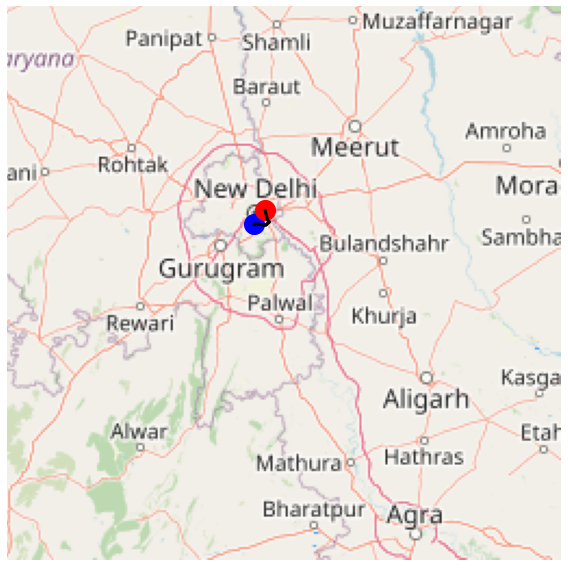

In [94]:
ax = m.show_mpl(figsize=(8, 8))

ax.plot(x, y, '-k', lw=3)
# Mark our two positions.
ax.plot(x[0], y[0], 'ob', ms=20)
ax.plot(x[-1], y[-1], 'or', ms=20)

# Mark the path.
ax.plot(x, y, '-k', lw=3)